In [1]:
import time
import numpy as np
import yaml
import autograd.numpy as np1
from scipy.optimize import Bounds
import torch
from torch import Tensor, optim
import torch.optim.lr_scheduler as lr_scheduler
from utils import circle_points, plot_trajectories

In [2]:
from tqdm import tqdm
from hypernet_MLP import Hypernet_MLP
from hypernet_trans import Hypernet_trans
import math

In [83]:
def set_seed(seed=702):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(702)

In [3]:
case = "_Ex_7_1"

In [4]:
import autograd.numpy as np
from scipy.optimize import minimize            
from scipy.optimize import BFGS
        
class Projection:
    def __init__(self, cons, bounds, dim, proj_type='euclid'):
        """
        cons: Ràng buộc (constraints)
        bounds: Giới hạn biên (bounds)
        n: Số chiều
        proj_type: Loại phép chiếu ('euclid' cho miền C hoặc 'qplus' cho miền Q+)
        """
        self.cons = cons
        self.bounds = bounds
        self.dim = dim
        self.proj_type = proj_type
        
        # Cấu hình hàm mục tiêu dựa trên loại phép chiếu
        if self.proj_type == 'qplus':
            self.objective_func = self._obj_positive_diff
        elif self.proj_type == 'euclid':
            self.objective_func = self._obj_l2_norm
        else:
            print(f"Phép chiếu {self.objective_func} không cài đặt, chọn 'qplus' hoặc 'euclid'")

    def _obj_l2_norm(self, x, y):
        """Hàm mục tiêu khoảng cách Euclid chuẩn (Dùng cho C)"""
        return np.sqrt(np.sum((x - y)**2))
    
    def _obj_positive_diff(self, x, y):
        """Hàm mục tiêu (Dùng cho Qplus)"""
        v = np.maximum(y - x, 0) 
        return np.sum(v**2)

    def project(self, target_point):
        """
        init_point: Điểm khởi tạo
        target_point: Điểm cần chiếu 
        """
        
        init_point = np.random.rand(1, self.dim).tolist()[0]
        
        res = minimize(
            self.objective_func,
            init_point,
            args=(target_point, ),
            constraints=self.cons,
            bounds=self.bounds,
            options={'disp': False}
        )
        
        optim_point = res.x
        
        if self.proj_type == 'qplus':
            return target_point - np.maximum(target_point - optim_point, 0)
        else:
            return optim_point

In [5]:
class Problem():
    def __init__(self, f, dim_x, dim_y, proj_C, proj_Qplus):
        self.f = f
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.proj_C = proj_C
        self.proj_Qplus = proj_Qplus
    
    def objective_func(self, x):
        vals = [func(x) for func in self.f]
        return np.concatenate(vals)  

# Define

In [6]:
def f1(x):
    return x[0]
def f2(x):
    return (x[0] - 1)**2
#--------------- C --------------------#
def c1(x):
    return x[0]
def c2(x):
    return -x[0] + 1


#--------------- Q --------------------#
def q1(y):
    return 0.2**2 - (y[0] - 0.4)**2 - (y[1] - 0.4)**2

def q_plus(y):
    center = .4
    radius_sq = 0.2**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

# Hàm dùng cho Projection 
cons_C = (
    {
        'type': 'ineq', 'fun' : c1,     
    },
    {
        'type': 'ineq', 'fun' : c2,     
    }
)

dim_x = 1
bounds_x = Bounds([-15,-15],[30, 30])
bounds_x = None
cons_Q = (
    {
        'type': 'ineq', 'fun' : q1,     
    },    
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus},
)
dim_y = 2

In [7]:
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f1, f2], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)
z_star = np.array([0.0, 0.0])

In [8]:
config_path='../4_Pareto_front/config.yaml'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
test_rays = np.array(cfg['data']['test_ray'])

In [9]:
def evaluate_objectives_single(functions, x_tensor):
    """
    Hàm phụ trợ: Tính giá trị f1(x), f2(x) cho 1 mẫu x duy nhất.
    """
    vals = []
    for func in functions:
        val = func(x_tensor)
        if not torch.is_tensor(val):
            val = torch.tensor(val, dtype=torch.float32)
        vals.append(val)
    return torch.stack(vals).reshape(-1)

def train_hypernet(hypernet, prob, z_star, 
                   num_epochs=1000, 
                   lr=1e-3, 
                   num_partitions=100, 
                   lr_step_size=300, 
                   lr_gamma=0.5,
                   # --- THAM SỐ THUẬT TOÁN 2-A (Monotonic Penalty) ---
                   # Cả hai đều TĂNG dần để đảm bảo Feasibility
                   beta_C_0=1.0,    # Giá trị khởi tạo cho C
                   beta_C_max=1000.0, # Giá trị tối đa cho C
                   rho_C=1.01,      # Tỷ lệ tăng cho C (VD: 1.01 = +1%/step)
                   
                   beta_Q_0=1.0,    # Giá trị khởi tạo cho Q (Algorithm 2-A: Tăng Q)
                   beta_Q_max=1000.0, # Giá trị tối đa cho Q
                   rho_Q=1.01,      # Tỷ lệ tăng cho Q
                   verbose=True): 
    
    # 1. Khởi tạo
    optimizer = optim.Adam(hypernet.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
    
    # Đảm bảo z_star chuẩn shape
    z_star_tensor = torch.tensor(z_star, dtype=torch.float32).view(1, -1)
    
    # Khởi tạo hệ số phạt (Step 1 của Alg 2-A)
    beta_C = beta_C_0
    beta_Q = beta_Q_0
    
    angle_step = (math.pi / 2) / num_partitions
    
    if verbose:
        print(f"=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===")
        print(f"Constraint C: Start {beta_C_0} -> Max {beta_C_max} (Rate {rho_C})")
        print(f"Constraint Q: Start {beta_Q_0} -> Max {beta_Q_max} (Rate {rho_Q})")
    
    for epoch in range(num_epochs):
        hypernet.train()
        optimizer.zero_grad()
        
        # --------------------------------------------------------
        # 1. Lấy mẫu phân tầng (Stratified Sampling - Step 4,5 of Alg 2-A)
        # --------------------------------------------------------
        starts = torch.arange(num_partitions) * angle_step
        noise = torch.rand(num_partitions) * angle_step
        thetas = starts + noise 
        
        r_batch_np = np.stack([np.cos(thetas.numpy()), np.sin(thetas.numpy())], axis=1)
        r_tensor_batch = torch.tensor(r_batch_np, dtype=torch.float32)
        
        # --------------------------------------------------------
        # 2. Lan truyền xuôi & Tính Loss (Step 8-18 of Alg 2-A)
        # --------------------------------------------------------
        
        # Forward pass (Sequential để tránh lỗi shape của Hypernet)
        x_pred_list = []
        for i in range(num_partitions):
            r_single = r_tensor_batch[i].unsqueeze(0)
            x_single = hypernet(r_single)
            x_pred_list.append(x_single)
            
        x_vec_batch = torch.cat(x_pred_list, dim=0) # Batch output
        
        # Loop tính Loss thành phần (do Scipy projection không hỗ trợ batch)
        x_np_batch = x_vec_batch.detach().cpu().numpy()
        loss_C_list = []
        loss_Q_list = []
        y_pred_list = []
        
        for i in range(num_partitions):
            x_i_tensor = x_vec_batch[i].reshape(-1) 
            x_i_np = x_i_tensor.detach().cpu().numpy()
            
            # a. Loss C: ||x - P_C(x)||^2
            x_proj_i_np = prob.proj_C(x_i_np)
            x_proj_i_tensor = torch.tensor(x_proj_i_np, dtype=torch.float32)
            loss_C_list.append(torch.sum((x_i_tensor - x_proj_i_tensor)**2))
            
            # b. F(x)
            y_pred_i = evaluate_objectives_single(prob.f, x_i_tensor)
            y_pred_list.append(y_pred_i)
            
            # c. Loss Q: ||y - P_Q+(y)||^2
            y_i_np = y_pred_i.detach().cpu().numpy()
            y_proj_i_np = prob.proj_Qplus(y_i_np)
            y_proj_i_tensor = torch.tensor(y_proj_i_np, dtype=torch.float32)
            loss_Q_list.append(torch.sum((y_pred_i - y_proj_i_tensor)**2))
        
        # Tính trung bình Loss (Mean L_C, Mean L_Q)
        y_pred_batch = torch.stack(y_pred_list)
        L_bar_C = torch.mean(torch.stack(loss_C_list))
        L_bar_Q = torch.mean(torch.stack(loss_Q_list))
        
        # --------------------------------------------------------
        # 3. Tính Loss Mục tiêu Chebyshev (Step 20-21 of Alg 2-A)
        # --------------------------------------------------------
        diff = y_pred_batch - z_star_tensor
        weighted_diff = r_tensor_batch * diff
        max_vals, _ = torch.max(weighted_diff, dim=1)
        L_Obj = torch.mean(max_vals)
        
        # --------------------------------------------------------
        # 4. Tổng hợp và Cập nhật (Step 24-27 of Alg 2-A)
        # --------------------------------------------------------
        # L_Total = L_Obj + β_C * L_C + β_Q * L_Q
        total_loss = L_Obj + (beta_C * L_bar_C) + (beta_Q * L_bar_Q)
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        # --------------------------------------------------------
        # 5. Cập nhật hệ số Phạt (Step 30-31 of Alg 2-A)
        # --------------------------------------------------------
        # Cả hai hệ số đều TĂNG dần
        beta_C = min(beta_C_max, beta_C * rho_C)
        beta_Q = min(beta_Q_max, beta_Q * rho_Q)
        
        # Logging
        if verbose and epoch % 20 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}: Total={total_loss.item():.3f} "
                  f"(Obj={L_Obj.item():.4f}, C={L_bar_C.item():.5f}, Q={L_bar_Q.item():.5f}) "
                  f"|| BetaC={beta_C:.1f}, BetaQ={beta_Q:.1f}")
            
    return hypernet

In [11]:
def infer(model, test_rays=test_rays):
    model.eval()
    pf_pred = [] 
    tmp_err = [] 
    t1 = time.time()
    print(f"Evaluating on {len(test_rays)} rays...")

    for r in test_rays:   
        # --- Dự đoán với Hypernetwork ---
        ray_t = torch.from_numpy(r).float().unsqueeze(0)
        with torch.no_grad(): 
            output_x = model(ray_t).flatten() 
            vals = [func(output_x).item() for func in prob.f]
            obj_pred = np.array(vals)

        pf_pred.append(obj_pred)
    t2 = time.time()
    pf_pred = np.array(pf_pred)
    print("-" * 30)
    # print(f"Mean L1 Error: {np.mean(tmp_err):.6f}")
    print(f"Inference Time: {t2-t1:.4f}s")
    return pf_pred

In [55]:
def calculate_mse(pf_pred, pf_true):
    pf_pred_ = np.array(pf_pred)
    pf_true_ = np.array(pf_true)
    
    if pf_pred_.shape != pf_true_.shape:
        print(f"⚠️ Warning: Shape mismatch {pf_pred_.shape} vs {pf_true_.shape}. MSE có thể không chính xác.")
        return np.inf

    return np.mean((pf_pred_ - pf_true_)**2)

# MLP

In [46]:
hnet_MLP = Hypernet_MLP(ray_hidden_dim=32, out_dim=prob.dim_x, n_tasks=2)

In [47]:
trained = train_hypernet(
    hnet_MLP, prob, z_star, 
    num_epochs=1000, 
    lr=1e-3, 
    num_partitions=50, 
    lr_step_size=300, 
    lr_gamma=0.5,
    # --- THAM SỐ THUẬT TOÁN 2-A (Monotonic Penalty) ---
    beta_C_0=1.0,    # Giá trị khởi tạo cho C
    beta_C_max=1000.0, # Giá trị tối đa cho C
    rho_C=1.01,      # Tỷ lệ tăng cho C 
    beta_Q_0=1.0,    # Giá trị khởi tạo cho Q (Algorithm 2-A: Tăng Q)
    beta_Q_max=1000.0, # Giá trị tối đa cho Q
    rho_Q=1.01,      # Tỷ lệ tăng cho Q
    verbose=True
)

=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 1000.0 (Rate 1.01)
Constraint Q: Start 1.0 -> Max 1000.0 (Rate 1.01) [MONOTONIC INCREASING]
Epoch 0: Total=1.0789 (Obj=0.7431, C=0.0069, Q=0.3289) || BetaC=1.0, BetaQ=1.0
Epoch 10: Total=0.7271 (Obj=0.5994, C=0.0000, Q=0.1156) || BetaC=1.1, BetaQ=1.1
Epoch 20: Total=0.4966 (Obj=0.4753, C=0.0000, Q=0.0175) || BetaC=1.2, BetaQ=1.2
Epoch 30: Total=0.3765 (Obj=0.3765, C=0.0000, Q=0.0000) || BetaC=1.4, BetaQ=1.4
Epoch 40: Total=0.3226 (Obj=0.3226, C=0.0000, Q=0.0000) || BetaC=1.5, BetaQ=1.5
Epoch 50: Total=0.3013 (Obj=0.3013, C=0.0000, Q=0.0000) || BetaC=1.7, BetaQ=1.7
Epoch 60: Total=0.2735 (Obj=0.2735, C=0.0000, Q=0.0000) || BetaC=1.8, BetaQ=1.8
Epoch 70: Total=0.2401 (Obj=0.2398, C=0.0000, Q=0.0002) || BetaC=2.0, BetaQ=2.0
Epoch 80: Total=0.2169 (Obj=0.2112, C=0.0000, Q=0.0026) || BetaC=2.2, BetaQ=2.2
Epoch 90: Total=0.2195 (Obj=0.2085, C=0.0000, Q=0.0045) || BetaC=2.5, BetaQ=2.5
Epoch 100: Total=0.2

Epoch 960: Total=0.2272 (Obj=0.2266, C=0.0000, Q=0.0000) || BetaC=1000.0, BetaQ=1000.0
Epoch 970: Total=0.2263 (Obj=0.2260, C=0.0000, Q=0.0000) || BetaC=1000.0, BetaQ=1000.0
Epoch 980: Total=0.2263 (Obj=0.2262, C=0.0000, Q=0.0000) || BetaC=1000.0, BetaQ=1000.0
Epoch 990: Total=0.2266 (Obj=0.2260, C=0.0000, Q=0.0000) || BetaC=1000.0, BetaQ=1000.0


# Transformer

In [18]:
hnet_trans = Hypernet_trans(ray_hidden_dim=32, out_dim=prob.dim_x, n_tasks=2)

In [19]:
trained = train_hypernet(
    hnet_trans, prob, z_star, 
    num_epochs=1000, 
    lr=1e-3, 
    num_partitions=100, 
    lr_step_size=300, 
    lr_gamma=0.5,
    # --- THAM SỐ THUẬT TOÁN 2-A (Monotonic Penalty) ---
    beta_C_0=1.0,    # Giá trị khởi tạo cho C
    beta_C_max=1000.0, # Giá trị tối đa cho C
    rho_C=1.01,      # Tỷ lệ tăng cho C 
    beta_Q_0=1.0,    # Giá trị khởi tạo cho Q (Algorithm 2-A: Tăng Q)
    beta_Q_max=1000.0, # Giá trị tối đa cho Q
    rho_Q=1.01,      # Tỷ lệ tăng cho Q
    verbose=True
)

=== TRAIN HYPERNET (Algorithm 2-A: Monotonic Penalty) ===
Constraint C: Start 1.0 -> Max 1000.0 (Rate 1.01)
Constraint Q: Start 1.0 -> Max 1000.0 (Rate 1.01) [MONOTONIC INCREASING]
Epoch 0: Total=0.4386 (Obj=0.4358, C=0.0000, Q=0.0027) || BetaC=1.0, BetaQ=1.0
Epoch 10: Total=0.3084 (Obj=0.3084, C=0.0000, Q=0.0000) || BetaC=1.1, BetaQ=1.1
Epoch 20: Total=0.2217 (Obj=0.2213, C=0.0000, Q=0.0003) || BetaC=1.2, BetaQ=1.2
Epoch 30: Total=0.2260 (Obj=0.2144, C=0.0000, Q=0.0086) || BetaC=1.4, BetaQ=1.4
Epoch 40: Total=0.2170 (Obj=0.2125, C=0.0000, Q=0.0030) || BetaC=1.5, BetaQ=1.5
Epoch 50: Total=0.2168 (Obj=0.2151, C=0.0000, Q=0.0011) || BetaC=1.7, BetaQ=1.7
Epoch 60: Total=0.2155 (Obj=0.2118, C=0.0000, Q=0.0020) || BetaC=1.8, BetaQ=1.8
Epoch 70: Total=0.2152 (Obj=0.2106, C=0.0000, Q=0.0023) || BetaC=2.0, BetaQ=2.0
Epoch 80: Total=0.2151 (Obj=0.2113, C=0.0000, Q=0.0017) || BetaC=2.2, BetaQ=2.2
Epoch 90: Total=0.2147 (Obj=0.2105, C=0.0000, Q=0.0017) || BetaC=2.5, BetaQ=2.5
Epoch 100: Total=0.2

Epoch 960: Total=0.2228 (Obj=0.2226, C=0.0000, Q=0.0000) || BetaC=1000.0, BetaQ=1000.0
Epoch 970: Total=0.2227 (Obj=0.2225, C=0.0000, Q=0.0000) || BetaC=1000.0, BetaQ=1000.0
Epoch 980: Total=0.2225 (Obj=0.2224, C=0.0000, Q=0.0000) || BetaC=1000.0, BetaQ=1000.0
Epoch 990: Total=0.2228 (Obj=0.2226, C=0.0000, Q=0.0000) || BetaC=1000.0, BetaQ=1000.0


# Test

In [41]:
pf_true = np.load(f"../4_Pareto_front/test/{case}/pf_dynamic_true.npy")
target_space = np.load(f"../4_Pareto_front/test/{case}/target_space.npy")

## MLP

In [116]:
pf_pred = infer(hnet_MLP)
calculate_mse(pf_pred, pf_true)

Evaluating on 20 rays...
------------------------------
Inference Time: 0.0022s


np.float64(0.003900400541809665)

<Figure size 1600x800 with 0 Axes>

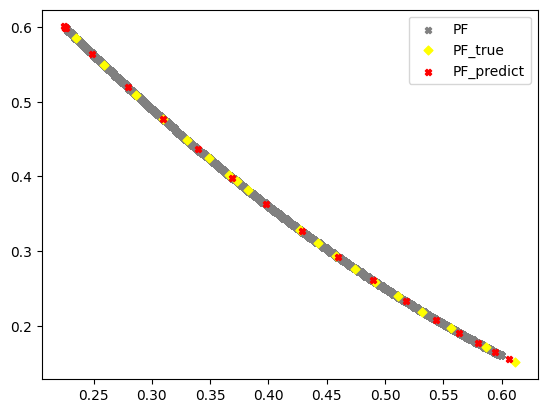

In [117]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=target_space , figsize=(16, 8))

## Trans

In [120]:
pf_pred = infer(hnet_trans)
calculate_mse(pf_pred, pf_true)

Evaluating on 20 rays...
------------------------------
Inference Time: 0.0077s


np.float64(0.004161277155175121)

<Figure size 1600x800 with 0 Axes>

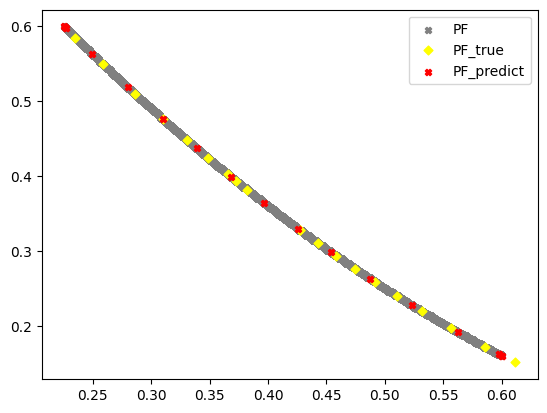

In [121]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=target_space , figsize=(16, 8))

# Best model

In [122]:
import os

In [123]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [124]:
import os
best_MLP = Hypernet_MLP(ray_hidden_dim=32, out_dim=dim_x, n_tasks=2)
best_trans = Hypernet_trans(ray_hidden_dim=32, out_dim=dim_x, n_tasks=2)
# 2. Đường dẫn file đã lưu
PATH_MLP = "model/_Ex_7_1/best_MLP_MSE.pth"
PATH_trans = "model/_Ex_7_1/best_trans_MSE.pth"
# 3. Load state dict
if os.path.exists(PATH_MLP):
    state_dict = torch.load(PATH_MLP, map_location=device)
    best_MLP.load_state_dict(state_dict)
    best_MLP.to(device)
    best_MLP.eval() 

if os.path.exists(PATH_trans):
    state_dict = torch.load(PATH_trans, map_location=device)
    best_trans.load_state_dict(state_dict)
    best_trans.to(device)
    best_trans.eval() 

# MSE

In [125]:
pf_pred = infer(best_trans)
calculate_mse(pf_pred, pf_true)

Evaluating on 20 rays...
------------------------------
Inference Time: 0.0069s


np.float64(0.0023571518344760512)

<Figure size 1600x800 with 0 Axes>

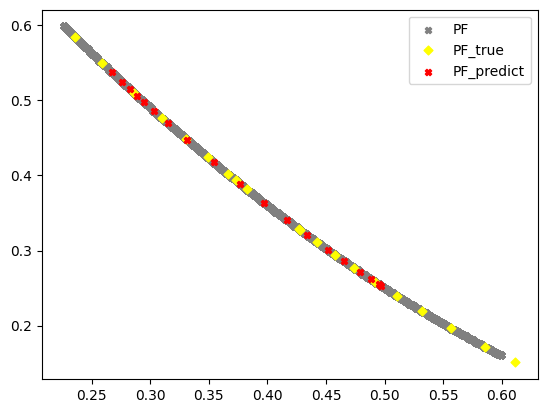

In [126]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=target_space , figsize=(16, 8))

In [118]:
pf_pred = infer(best_MLP)
calculate_mse(pf_pred, pf_true)

Evaluating on 20 rays...
------------------------------
Inference Time: 0.0023s


np.float64(0.0036544856578983992)

<Figure size 1600x800 with 0 Axes>

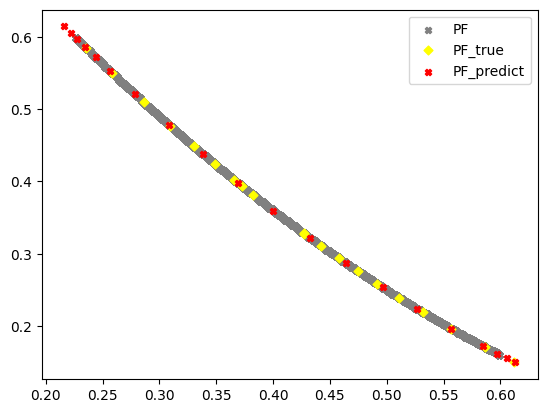

In [119]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=target_space , figsize=(16, 8))